# CA6 - Clustering

In this project, we intend to solve the classification problem of data collected from Asre Iran news agency using different unsupervised clustering algorithms.

Initially, we preprocess our data. Then, we use the KMeans and DBSCAN algorithms to solve the problem. After that, we evaluate our models using the homogeneity criterion and silhouette score. For preprocessing the data, since our data was in Persian, we used the `hazm` library.

At the beginning of our code, we import the necessary libraries and load our data.

In [2]:
from hazm import *
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import multiprocessing
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import homogeneity_score, silhouette_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...,...,...
8995,حوادث,شانزدهم مهر امسال درپی تماس با مرکز فوریت‌های ...
8996,ورزشی,اتحادیه فوتبال ترینیداد و توباگو اعلام کرده تی...
8997,فرهنگی/هنری,اسامی 18 فیلم بخش مسابقه مستند ششمین دوره جشنو...
8998,حوادث,کامیونت حامل بار تخته‌های چوبی عصر دیروز چهارش...


In [5]:
train_df.describe()

,label,content
count,9000,9000
unique,6,8980
top,فناوری,منبع: ایسنا
freq,1500,4


In [6]:
train_df['label'].value_counts()

label
فناوری         1500
ورزشی          1500
حوادث          1500
سلامت          1500
سیاسی          1500
فرهنگی/هنری    1500
Name: count, dtype: int64

In [7]:
test_df['label'].value_counts()

label
حوادث          200
سیاسی          200
ورزشی          190
فرهنگی/هنری    180
سلامت          177
فناوری         168
Name: count, dtype: int64

1. **Imbalanced data challenges in clustering process and strategies**
- Challenges: 
    - **Bias towards Majority Class**: Clustering algorithms may be biased towards the majority class, leading to clusters that predominantly represent the majority class. This can result in poor representation of minority classes.

    - **Difficulty in Identifying Minority Clusters**: Minority classes may be treated as noise or outliers, making it difficult to identify meaningful clusters within these classes.

    - **Poor Evaluation Metrics**: Traditional evaluation metrics may not accurately reflect the performance of a clustering algorithm on imbalanced data.

- Strategies:
    - **Resampling Techniques**: You can either oversample the minority class or undersample the majority class to achieve a more balanced dataset.

    - **Anomaly Detection**: Treat the minority class as an anomaly and use anomaly detection techniques to identify these instances.

    - **Using Appropriate Evaluation Metrics**: Use evaluation metrics that are less sensitive to class imbalance, such as the Silhouette Coefficient or Dunn Index.

    - **Cost-Sensitive Learning**: Assign higher misclassification costs to the minority class during model training to increase its importance.

    - **Ensemble Methods**: Create multiple subsets of the original data, create a clustering model for each subset, and then combine the results

## **Preprocessing Data**

In [8]:
normalizer = Normalizer()
stemmer = Stemmer()
sw = stopwords_list()
lemmatizer = Lemmatizer()
stemmer = Stemmer()


In [9]:
def preprocess_text(text):
    normalized_text = normalizer.normalize(text)
    punct_normalized = re.sub(r'[^\w\s]', '', normalized_text)
    tokens = word_tokenize(punct_normalized)
    tokens_without_stopwords = [token for token in tokens if token not in sw]
    tokens_without_numbers = [re.sub(r'\d+', '', token) for token in tokens_without_stopwords]
    tokens_root = [lemmatizer.lemmatize(token) for token in tokens_without_numbers]
    non_empty_tokens = [token for token in tokens_root if token.strip() != '']
    return ' '.join(non_empty_tokens)

In [10]:
train_df['content'][0]

'گزارش های منتشر شده حاکی از آن است که کاربران تلگرام در مناطقی از جهان همچون اروپا و خاورمیانه با مشکل مواجه شده اند. به گزارش ایسنا، به نقل از تلگرام، دقایقی پیش پیام رسان تلگرام در صفحه توییتر خود اعلام کرد که دسترسی کاربران این اپلیکیشن در اروپا و خاورمیانه با مشکل مواجه شده است. طبق این پیام، به نظر می رسد که منشا این اختلالات از ظهر امروز، پنج شنبه، خارجی و از سوی خود این پیام رسان بوده است و ارتباطی با داخل کشور ندارد. این پیام رسان در این خصوص عنوان کرده است که متخصصان تلگرام از زمانی که متوجه چنین اختلالی شده اند، در حال بررسی و برطرف کردن مشکل مربوطه بوده و امید است به زودی این اختلال رفع شود و کاربران به حساب های کاربری خود در تلگرام دسترسی یابند.'

In [11]:
train_df['content'] = train_df['content'].apply(preprocess_text)
test_df['content'] = test_df['content'].apply(preprocess_text)

2. **Stemming and Lemmatization**

Stemming and lemmatization are both ways used in language processing to simplify words to their basic form. But they do this in different ways:

- **Stemming**: This is a basic method that cuts off the ends of words hoping to get this right most of the time. It uses a simple approach and works on simplifying words to their stem or root form.
    - The stem of “am”, “are”, “is” might be “am”, “ar”, “is” respectively.

- **Lemmatization**: This is a more advanced method that looks at the structure of the words and correctly identifies the base form for each word. To do this, it needs to have detailed word lists which the method can use to connect the word back to its base form.
    - The lemma of “am”, “are”, “is” is “be”.



## **Problem-solving process**

In [12]:
data = pd.concat([train_df, test_df])

In [13]:
tagged_train = [TaggedDocument(words=text.split(), tags=[str(label)]) for text, label in zip(train_df['content'], train_df['label'])]
tagged_data = [TaggedDocument(words=text.split(), tags=[str(label)]) for text, label in zip(data['content'], data['label'])]

In [14]:
tagged_train[0:5]

[TaggedDocument(words=['گزارش', 'منتشر', 'حاکی', 'کاربر', 'تلگرام', 'مناطقی', 'جهان', 'اروپا', 'خاورمیانه', 'مشکل', 'شدهاند', 'گزارش', 'ایسنا', 'نقل', 'تلگرام', 'دقایق', 'پیامرسان', 'تلگرام', 'صفحه', 'توییتر', 'اعلام', 'دسترسی', 'کاربر', 'اپلیکیشن', 'اروپا', 'خاورمیانه', 'مشکل', 'پیام', 'میرسد', 'منشا', 'اختلالات', 'ظهر', 'امروز', 'پنجشنبه', 'خارجی', 'پیامرسان', 'ارتباطی', 'داخل', 'کشور', 'پیامرسان', 'عنوان', 'متخصص', 'تلگرام', 'زمانی', 'متوجه', 'اختلال', 'شدهاند', 'بررسی', 'برطرف', 'مشکل', 'مربوطه', 'امید', 'زودی', 'اختلال', 'رفع', 'کاربر', 'حساب', 'کاربری', 'تلگرام', 'دسترسی', 'یابید#یاب'], tags=['فناوری']),
 TaggedDocument(words=['سوپر', 'استار', 'سینما', 'قهرمان', 'سابق', 'ووشو', 'کونگفو', 'حضور', 'شهر', 'شانگهای', 'مسابقات', 'ووشو', 'قهرمانی', 'جهان', 'شاهد', 'گزارش', 'روابط', 'عمومی', 'فدراسیون', 'ووشو', 'آنتونی', 'گو', 'نایبرئیس', 'اجرایی', 'فدراسیون', 'جهانی', 'ووشو', 'افتخار', 'اعلام', 'جت', 'لی', 'محل', 'برگزاری', 'رقابت', 'ووشو', 'قهرمانی', 'بزرگسال', 'جهان', 'حضور', 'بههم',

In [15]:
le = LabelEncoder()
true_labels= le.fit_transform(data['label'])

In [87]:
model = Doc2Vec(dm=0, vector_size=100, min_count=1, workers=multiprocessing.cpu_count())
model.build_vocab(tagged_train)
model.train(tagged_train, total_examples=model.corpus_count, epochs=100)

In [88]:
vectors = [model.infer_vector(doc.words) for doc in tagged_data]

In [92]:
kmeans_model = KMeans(n_clusters=6, max_iter = 100)
kmeans_model.fit(vectors)
kmean_labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

In [149]:
dbscan = DBSCAN(eps=.34444435, min_samples=16, metric='cosine')
dbscan_labels = dbscan.fit_predict(vectors)

In [150]:
kmeans_homogeneity = homogeneity_score(true_labels, kmean_labels)
kmeans_silhouette = silhouette_score(vectors, kmean_labels)
print(f"KMeans Homogeneity: {kmeans_homogeneity}")
print(f"KMeans Silhouette Score: {kmeans_silhouette}")

dbscan_homogeneity = homogeneity_score(true_labels, dbscan_labels)
print(f"DBSCAN Homogeneity: {dbscan_homogeneity}")
dbscan_silhouette = silhouette_score(vectors, dbscan_labels)
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")


KMeans Homogeneity: 0.8744841735093247
KMeans Silhouette Score: 0.0777653306722641
DBSCAN Homogeneity: 0.3958978283015548
DBSCAN Silhouette Score: 0.01019616611301899


In [102]:
def plot_clusters(vectors, labels, centers=None, title='Clustering'):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 7))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')

    if centers is not None:
        centers_pca = pca.transform(centers)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x')

    plt.title(title)
    plt.show()


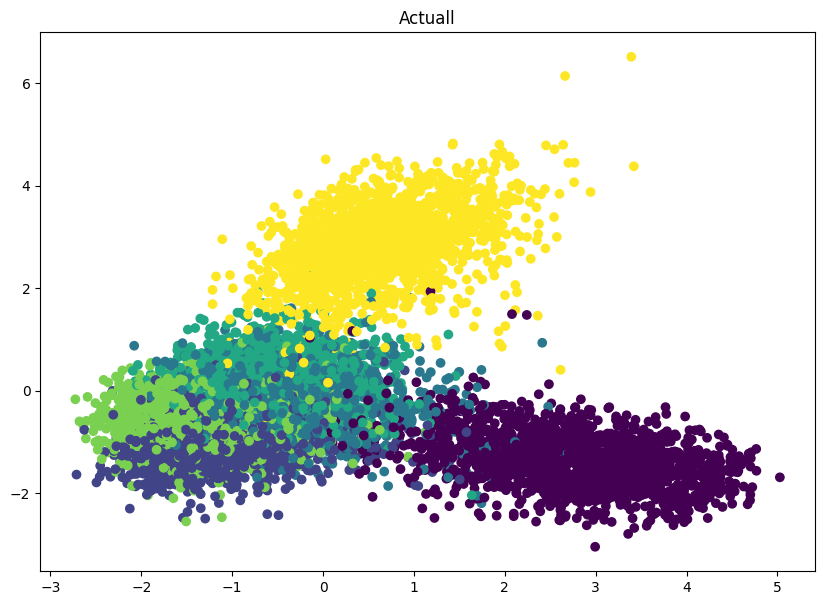

In [103]:
plot_clusters(vectors, true_labels, title='Actuall')

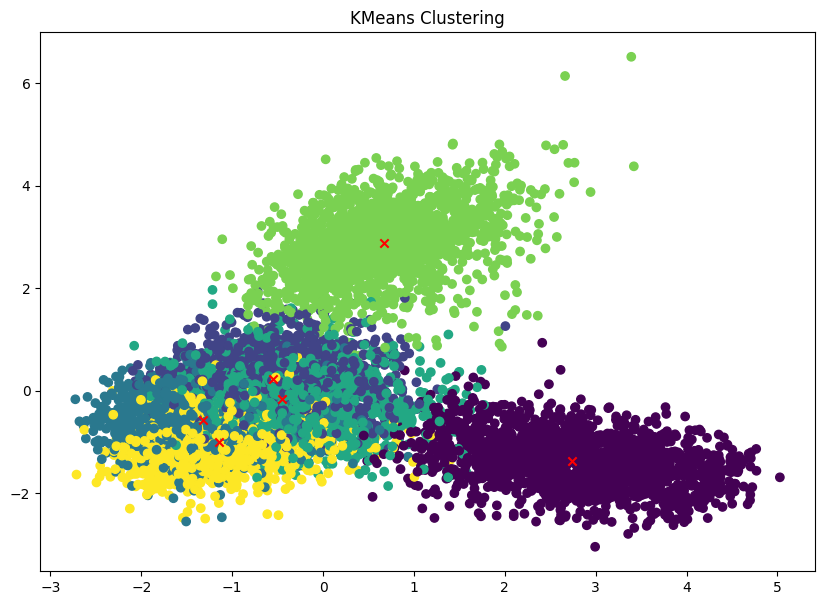

In [106]:
plot_clusters(vectors, kmean_labels, centers=centers, title='KMeans Clustering')

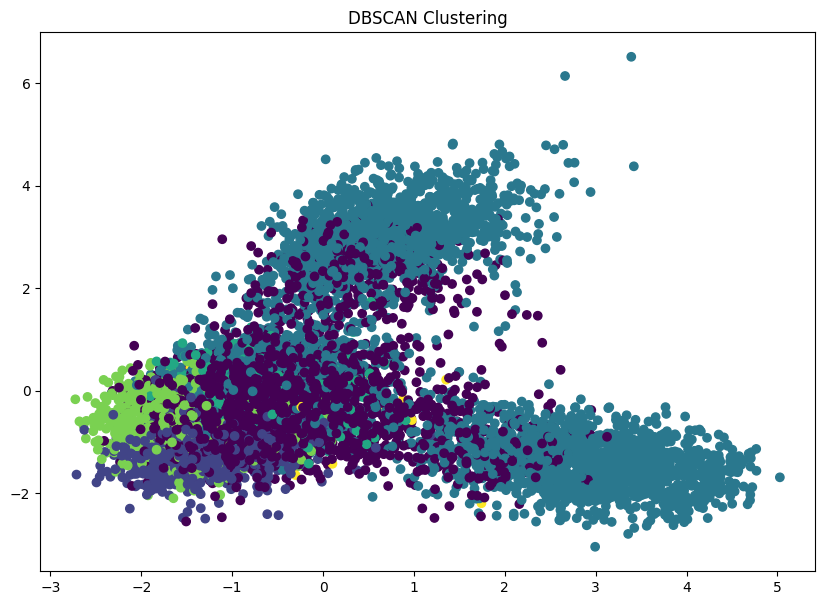

In [151]:
plot_clusters(vectors, dbscan_labels, title='DBSCAN Clustering')

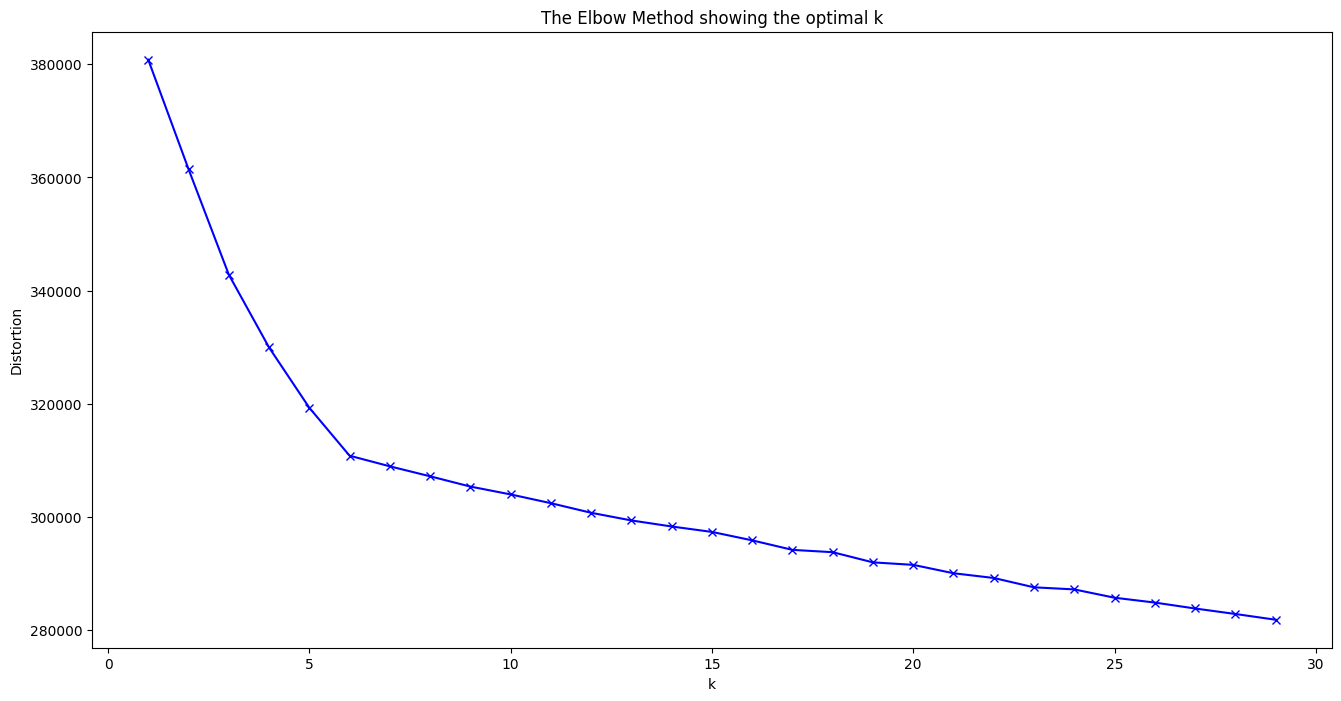

In [136]:
import matplotlib.pyplot as plt
distortions = []
K = range(1,30)
for k in K:
    kmeanModel =  KMeans(n_clusters=k, init= 'k-means++',n_init= 20, max_iter= 500 , random_state=1)
    kmeanModel.fit(vectors)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
